# Guess Core and use other methods to interpolate

In [1]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
from BlockMatrix import BlockMatrix
from tensorflow.keras.callbacks import TensorBoard
import datetime

#! Only if there are no cudo CPUs in the system!
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


2025-04-22 11:11:41.860909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 11:11:41.897574: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 11:11:42.160114: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 11:11:42.603964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745313103.623678   15429 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745313103.76

### 1b) Try on other dataset!

In [33]:
import sys, os
from glob import glob
sys.path.append("..")
from utils import  plot_mat_comp, flatten_triang_batch, flatten_triang, get_overlap, load_mol, unflatten_triang, density_from_fock, perform_calculation
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap


In [3]:
train_test_seed = 42
source_path = '../../datasets/QM9/xyz_c7h10o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
n_elec = 19
len(all_file_paths)


6095

In [4]:
def load_cached(file_paths, cache_path, basis, guess="minao", method="dft", functional="b3lypg", backend="pyscf"):
    error_list = []
    error_files = []
    focks = []
    overlaps = []
    used_files = []
    reference_densities = []
    for file in file_paths:
        mol_name = os.path.basename(file).strip()
        # print(mol_name)
        try: 
            ret = density_fock_overlap(filepath = file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
            # print(f"Using: file={file} - mol_name={mol_name} - basis={None} - guess={guess} - method={method} - functional={functional}")
        except Exception as e: 
            error_list.append(e)
            error_files.append(mol_name)
            print(f"File {mol_name} error - skipping")
            continue
        if any([r == None for r in ret]): 
            print(f"File {mol_name} bad - skipping")
            continue
        focks.append(ret[1].numpy)
        used_files.append(file)
        reference_densities.append(ret[0].numpy)
        overlaps.append(ret[2].numpy)
    print(f"Got data for: {len(focks)} - bad / no ret: {len(file_paths) - len(focks) - len(error_list)} - errors: {len(error_list)}")
    print(error_files[:5])
    return focks, reference_densities, overlaps, used_files


In [17]:
ret = load_cached(all_file_paths, "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)/pyscf", basis="6-31g_2df_p_custom_nwchem.gbs")

File dsgdb9nsd_083689.xyz bad - skipping
File dsgdb9nsd_056680.xyz bad - skipping
File dsgdb9nsd_079189.xyz bad - skipping
File dsgdb9nsd_060790.xyz bad - skipping
File dsgdb9nsd_038680.xyz bad - skipping
Got data for: 6090 - bad / no ret: 5 - errors: 0
[]


In [18]:
from sklearn.model_selection import train_test_split
train_test_seed = 42
all_data = [(fock, ref_density, overlap, file) for fock, ref_density, overlap, file in zip(*ret)]
print(len(all_data))
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=train_test_seed) 

6090


In [19]:
mat_dim = train_data[0][0].shape
mat_dim

(284, 284)

In [20]:
train_overlap_X = np.array([flatten_triang(data[2]) for data in train_data])
# train_fock_Y = np.array([data[0] for data in train_data])
train_fock_diag = np.array([np.diag(data[0]) for data in train_data])

test_overlap_X = np.array([flatten_triang(data[2]) for data in test_data])
# test_fock_Y = np.array([data[0] for data in test_data])
test_fock_diag = np.array([np.diag(data[0]) for data in test_data])
train_overlap_X.shape, test_overlap_X.shape

((4872, 40470), (1218, 40470))

In [10]:
import pickle as pk
with open("data/train_overlap_X.pk", "wb") as f:
    pk.dump(train_overlap_X, f)
with open("data/train_fock_diag.pk", "wb") as f:
    pk.dump(train_fock_diag, f)
with open("data/test_overlap_X.pk", "wb") as f:
    pk.dump(test_overlap_X, f)
with open("data/test_fock_diag.pk", "wb") as f:
    pk.dump(test_fock_diag, f)

In [7]:
# load data
import pickle as pk
with open("data/train_overlap_X.pk", "rb") as f:
    train_overlap_X = pk.load(f)
with open("data/train_fock_diag.pk", "rb") as f:
    train_fock_diag = pk.load(f)
with open("data/test_overlap_X.pk", "rb") as f:
    test_overlap_X = pk.load(f)
with open("data/test_fock_diag.pk", "rb") as f:
    test_fock_diag = pk.load(f)

In [8]:
custom_631g_basis = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
example_mol_filepath = os.path.basename(train_data[0][3]).strip()
example_mol = load_mol(train_data[0][3], custom_631g_basis, Backend.PY)
example_ovlp = unflatten_triang(train_overlap_X[0], mat_dim[0])
example_overlap = BlockMatrix(example_mol, example_ovlp)
example_overlap.plot_blocks_by_type("all", labels="atoms", figsize=(10, 10), imshow_args={"cmap": "RdBu"})

NameError: name 'train_data' is not defined

let's try our luck! - no rescaling for now 

In [9]:
import tensorflow as tf
in_dim = train_overlap_X.shape[1]
out_dim = train_fock_diag.shape[1]
in_dim, out_dim

(40470, 284)

In [24]:
tf.random.set_seed(42)
flattened_dim = train_overlap_X.shape[1]
diag_dim = train_fock_diag.shape[1]
inputs_orig = tf.keras.Input(shape=(flattened_dim,))
x = inputs_orig
for neurons in [1024,512,256]:
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(diag_dim)(x)

basic_model = tf.keras.Model(inputs=inputs_orig, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse"])

2025-04-22 10:47:54.188071: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
basic_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40470)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    41,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 284)            │        72,988 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,178,588 (160.90 MB)

 Trainable params: 42,175,004 (160.88 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/basic_model_6_31G.h5", save_best_only=True)
basic_hist = basic_model.fit(train_overlap_X, train_fock_diag,
                            validation_data=(test_overlap_X, test_fock_diag),
                            epochs=100,
                            batch_size=32,
                            callbacks=[tensorboard_callback, checkpoint_callback],
                            verbose=1)
# Plot the training and validation loss
plt.plot(basic_hist.history['loss'], label='train')
plt.plot(basic_hist.history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 50s 320ms/step - loss: 2.0485 - mse: 9.9209 - val_loss: 0.6972 - val_mse: 2.5154
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - loss: 0.6194 - mse: 2.1294 - val_loss: 0.3048 - val_mse: 0.8322
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 261ms/step - loss: 0.4177 - mse: 1.0540 - val_loss: 0.2660 - val_mse: 0.7490
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - loss: 0.3691 - mse: 0.9842 - val_loss: 0.2608 - val_mse: 0.6925
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - loss: 0.3402 - mse: 0.8906 - val_loss: 0.2455 - val_mse: 0.6919
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 0.3187 - mse: 0.8319 - val_loss: 0.2180 - val_mse: 0.5688
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - loss: 0.2914 - mse: 0.7195 - val_loss: 0.2088 - val_mse: 0.5525
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - loss: 0.2845 - mse: 0.7113 - val_loss: 0.2079 - val_mse: 0.5534
Epoch 9/100
153/153 ━━━━

KeyboardInterrupt: 

In [28]:
os.makedirs("models", exist_ok=True)
if os.path.exists("models/basic_model_6_31G.keras") and input("Overwrite existing model? (y/n)") == "y":
    os.remove("models/basic_model_6_31G.keras")
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")
else:
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")

Model saved


In [13]:
# load model
loaded_model = tf.keras.models.load_model("models/basic_model_6_31G.keras")
basic_model = loaded_model

In [14]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

In [15]:
# predict: 
test_pred_fock_diag = basic_model.predict(test_overlap_X)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


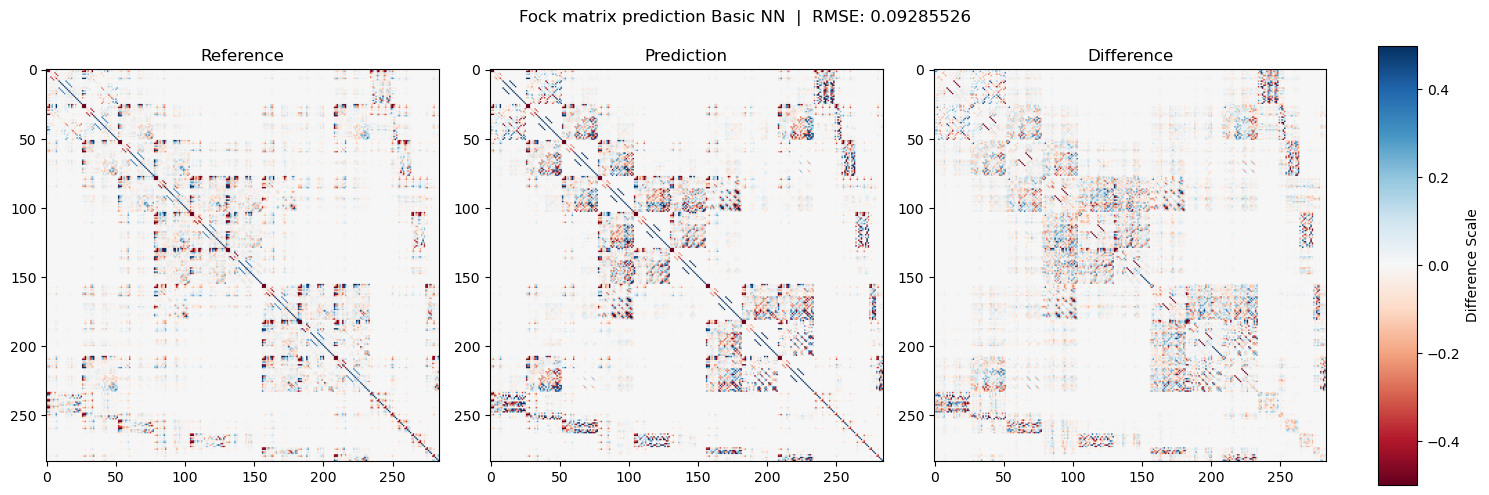

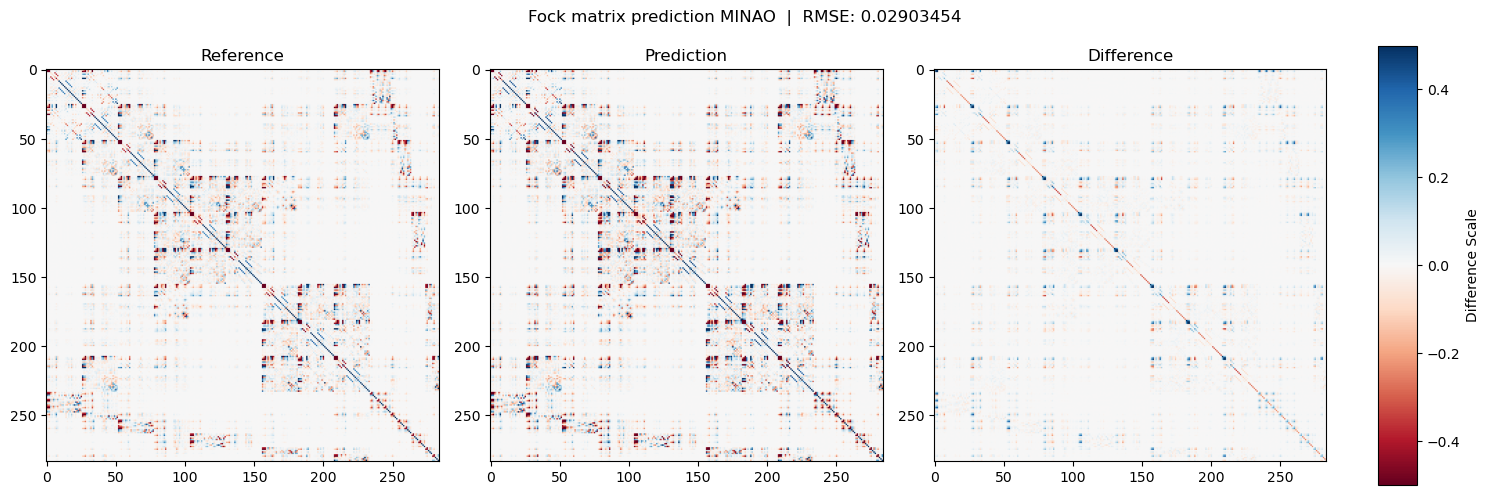

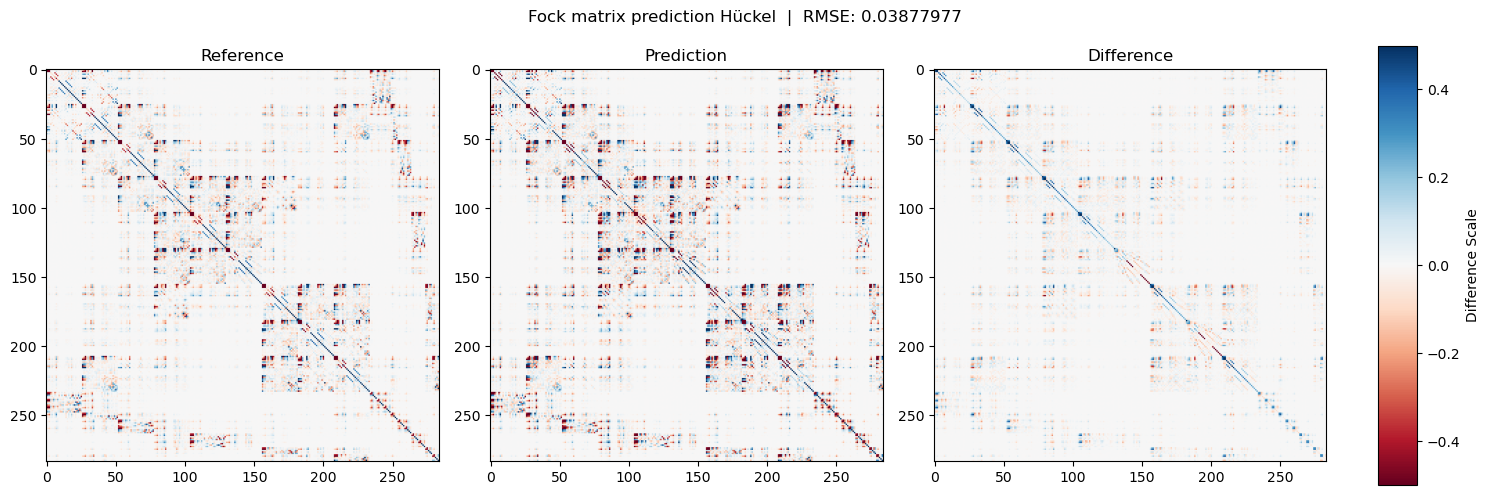

In [39]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_pred_fock_diag))
pred_fock_example = reconstruct_Fock(test_pred_fock_diag[rand_test_sample], unflatten_triang(test_overlap_X[rand_test_sample], mat_dim[0]))
ground_truth_fock_example = test_data[rand_test_sample][0]
pred_density_example = density_from_fock(pred_fock_example, unflatten_triang(test_overlap_X[rand_test_sample], mat_dim[0]), mat_dim[0])
# compare with hückel and minao
test_mol = load(test_data[rand_test_sample][3], symmetry=False, basis = custom_631g_basis, backend=Backend.PY)
minao_guess = guess(test_mol, method="hf", basis=custom_631g_basis, scheme="minao")
hueckel_guess = guess(test_mol, method="hf", basis=custom_631g_basis, scheme="huckel")
plot_mat_comp(ground_truth_fock_example, pred_fock_example, title="Fock matrix prediction Basic NN", vmax=0.5)
plot_mat_comp(ground_truth_fock_example, minao_guess.fock().numpy, title="Fock matrix prediction MINAO", vmax=0.5)
plot_mat_comp(ground_truth_fock_example, hueckel_guess.fock().numpy, title="Fock matrix prediction Hückel", vmax=0.5)

In [30]:
# test sim
minao_res = calculate(test_mol, method="dft", functional="b3lypg", basis=custom_631g_basis, guess="minao")

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.119839419214


In [31]:
huckel_res = calculate(test_mol, method="dft", functional="b3lypg", basis=custom_631g_basis, guess="huckel")

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.119839419205


In [34]:
nn_res = perform_calculation(test_data[rand_test_sample][3], pred_density_example, method="dft", functional="b3lypg", basis_set=custom_631g_basis)

converged SCF energy = -423.119839419504


In [37]:
print(minao_res.native.cycles)
print(huckel_res.native.cycles)
print(nn_res["cycles"])

11
15
25
